In [2]:
# default modules
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Callable, Union
%matplotlib inline
import os
import pickle
import shelve
import functools
import time
import logging
import pprint
import re
import itertools

import warnings
warnings.simplefilter('ignore')

from scipy import stats
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

def dict2array(items) -> Tuple[np.array, np.array]:
    array = np.array(list(items))
    return array.reshape(len(items), 1)

titanic = sns.load_dataset('titanic')
iris = sns.load_dataset('iris')

In [2]:
import plotly.express as px

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

#### matrix multiplication

In [46]:
a = np.array([
    [1,2],
    [3,4],
    [4,3],
    [2,1],
])
b = np.arange(1,5).reshape(2,2)

In [47]:
a.dot(b)

array([[ 7, 10],
       [15, 22],
       [13, 20],
       [ 5,  8]])

### dispersion

how a variable is spread out around its central tendency ie mean, median, mode etc

#### range

max minus the min

In [48]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [49]:
samp = np.random.randn(200)

In [50]:
rng = max(samp) - min(samp)
rng

4.999558975844259

#### variance

In [51]:
xhat = np.mean(samp)
xhat

-0.025338658434083783

In [52]:
sse = sum([(x-xhat)**2 for x in samp])

In [53]:
var = sse / (len(samp -1))
var

1.0327915420761302

In [54]:
variance = np.var(samp)
variance

1.0327915420761302

#### standard deviation

standard deviation is simple the square root of the variance and is comparable to the variable units
- 1 sd = 68%
- 2 sd = 95%
- 3 sd = 97.8%

In [55]:
np.sqrt(variance)

1.0162635199967232

In [56]:
std = np.std(samp)
stdlow1 = xhat - std
stdlow2 = stdlow1 - std
stdlow3 = stdlow2 - std

stdhigh1 = xhat + std
stdhigh2 = stdhigh1 + std
stdhigh3 = stdhigh2 + std

std_1 = (samp > stdlow1) & (samp < stdhigh1)
std_2 = (samp > stdlow2) & (samp < stdhigh2)
std_3 = (samp > stdlow3) & (samp < stdhigh3)

In [57]:
# 68% of the values within 1 standard deviation
sum(std_1) / len(samp)

0.65

In [58]:
# half of the values are on one side of the mean
sum(samp < xhat) / len(samp)

0.525

In [59]:
sum(std_2) / len(samp)

0.95

In [60]:
df = pd.DataFrame(samp, columns=['points'])

In [61]:
df['cats'] = np.where(std_1, 'std1', 'other')
df.loc[~std_1, 'cats'] = 'std2'
df.loc[~std_2, 'cats'] = 'std3'

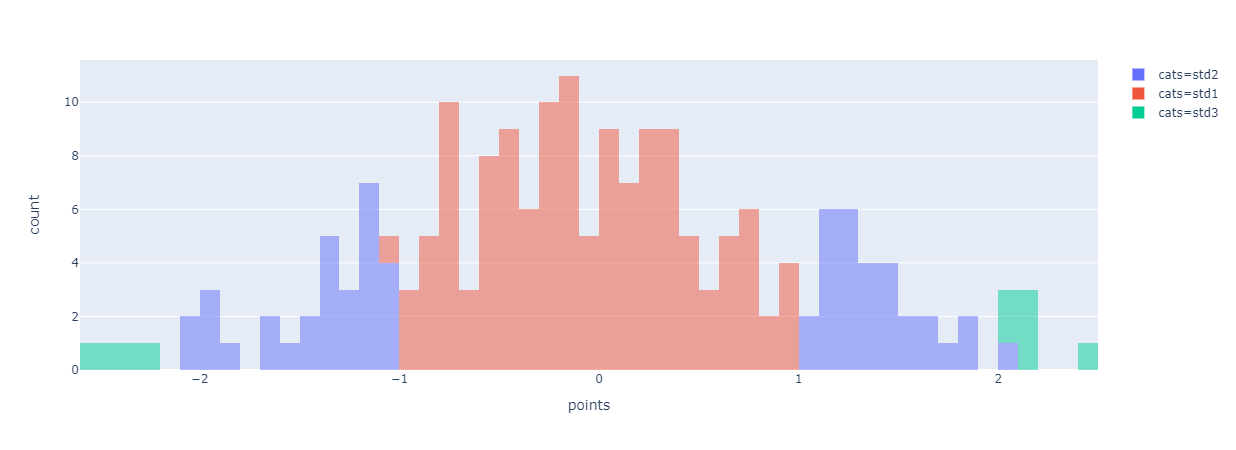

In [62]:
fig = px.histogram(df, x='points', color='cats', nbins=70, opacity=0.5)
fig.show()

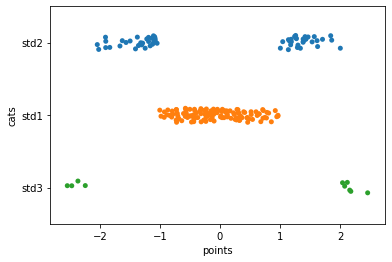

In [63]:
sns.stripplot(x='points', y='cats', data=df)

#### quartiles and IQR

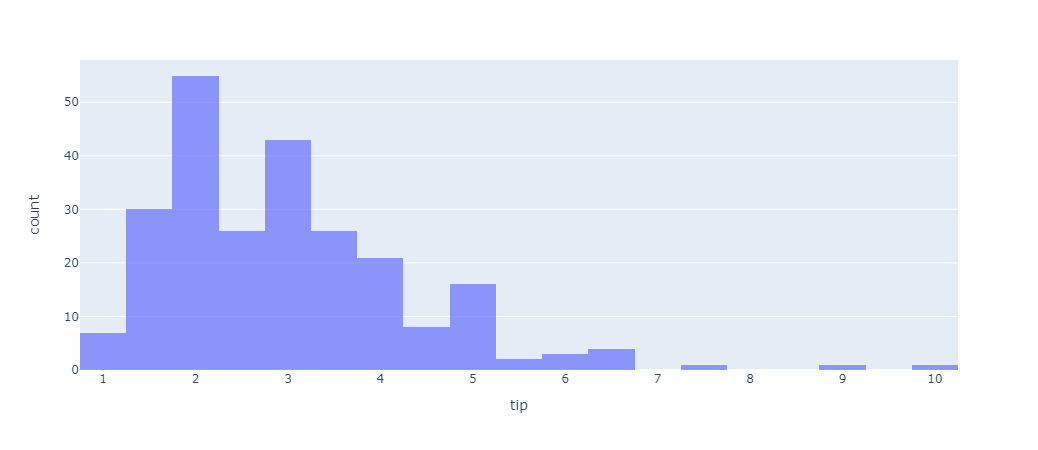

In [91]:
tips = sns.load_dataset('tips')
px.histogram(tips, 'tip', nbins=30, opacity=0.7)

outliers are considered to be 1.5x the interquatiles range from the upper/lower quartile

In [117]:
q_lower, q_upper = np.percentile(tips['tip'], (25, 75))
iqr = q_upper - q_lower
outliers_mask = tips['tip'] > (q_upper + (iqr*1.5))
print(sum(outliers_mask))
tips['outlier'] = np.where(outliers_mask, 1, 0)

9


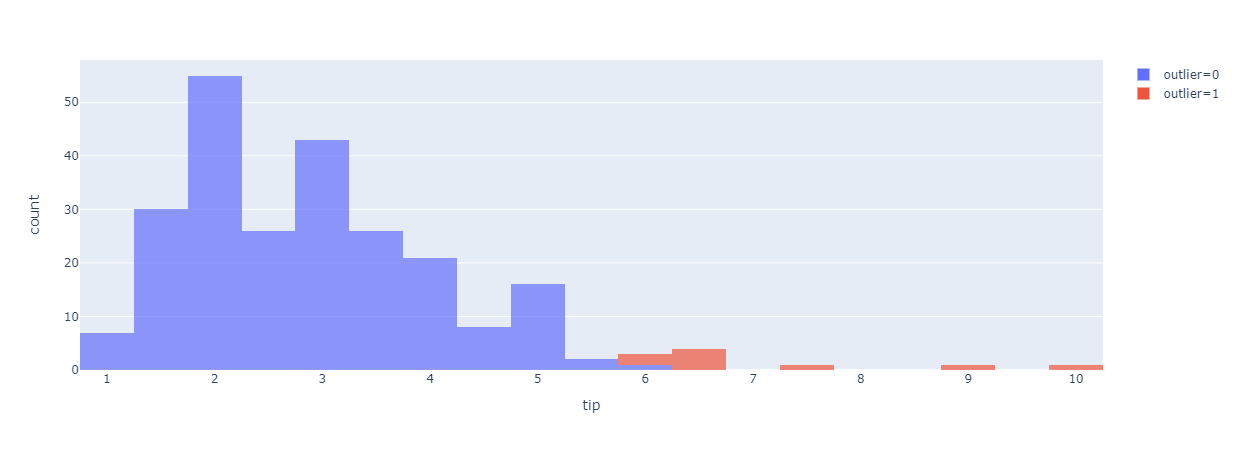

In [119]:
px.histogram(tips, 'tip', color='outlier', opacity=0.7)

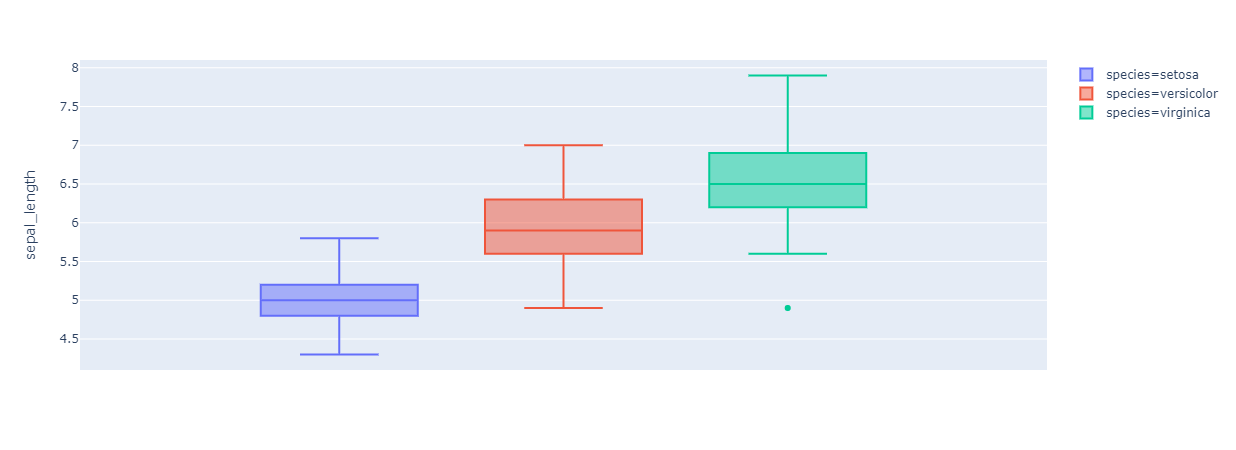

In [81]:
px.box(iris, y='sepal_length', color='species')

### bivariate data

#### covariance

In [123]:
justtips = tips[['tip', 'total_bill']]

In [130]:
covar = np.cov(justtips.values, rowvar=False)

In [131]:
covar

array([[ 1.91445464,  8.32350163],
       [ 8.32350163, 79.25293861]])

In [132]:
justtips.corr()

,tip,total_bill
tip,1.000000,0.675734
total_bill,0.675734,1.000000


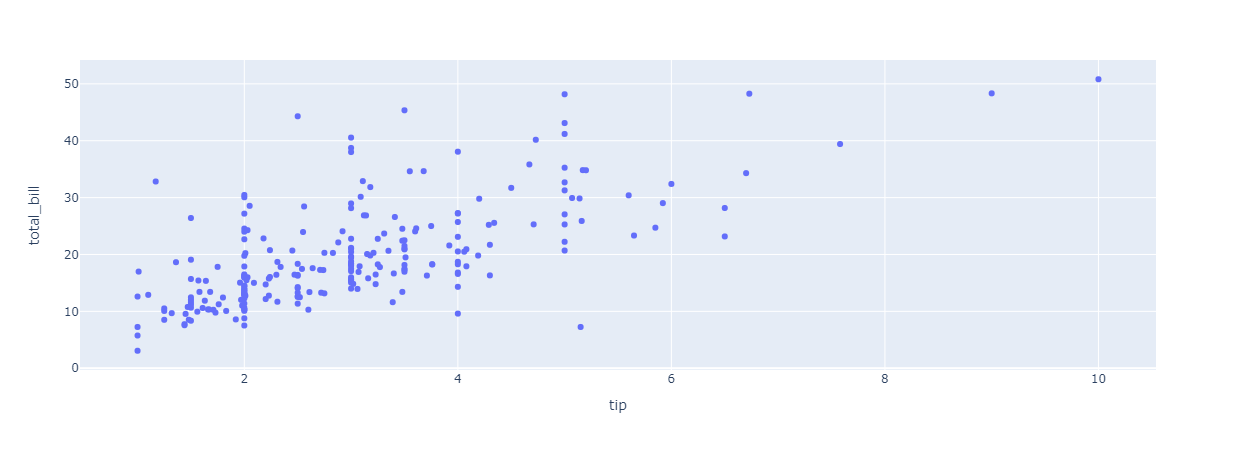

In [133]:
px.scatter(justtips, 'tip', 'total_bill')

#### confidence intervals

In [ ]:
def bootstrap_sample(sample, n_boots):
    """"""
    data = []
    for i in range(n_boots):
        bs = {}
        bs['idx'] = i
        bs['points'] = np.random.choice(sample, len(sample))
        bs['mean'] = np.mean(bs['points'])
        data.append(bs)
    return data

In [ ]:
x = iris['sepal_length']
x.shape

In [ ]:
x = np.random.choice(x, 100, replace=False)
x = pd.Series(x)

In [ ]:
# calculating the standard deviation, standard error and confidence intervals

m = np.mean(x)

std = np.sqrt(sum((x - np.mean(x))**2) / len(x))
np.std(x)

se = std / np.sqrt(len(x))

z = stats.t.ppf(1-0.025, len(x))
ci_low, ci_high = m - (z * se), m + (z * se) # sample mean plus/minus the margin of error ie (z value time standard error)

In [ ]:
# boot strapping
bs = bootstrap_sample(x, 3000)

In [ ]:
# bootstrapped means
u = [samp['mean'] for samp in bs]
rng = range(len(u))

In [ ]:
# the smaller the sample the bigger the confidence interval because 
# the standard deviation of the normal distribution increases, see t table
fig, ax = plt.subplots(1, 1, figsize=(9, 5.5))
ax.plot(m, 'bo')
ax.plot(np.arange(len(u)), np.ones(len(u)) * ci_low, 'r')
ax.plot(np.arange(len(u)), np.ones(len(u)) * ci_high, 'r')
ax.plot(rng, u, 'o', alpha=0.1)
plt.ylim([4.3, 7.9])

### distributions

In [ ]:
from scipy.stats import norm
import numpy.random as r
norm.pdf(0, loc=0, scale=0.1)
dist = r.randn(1000, 2)

fig, ax = plt.subplots()
ax.scatter(dist[:,0], dist[:,1] * 2 + 1, alpha=0.3)
ax.axis('equal')
fig.show()

#### multivariate distribution

In [ ]:
from scipy.stats import multivariate_normal as mvn

In [ ]:
cov = np.array([
    [1, 2],
    [2, 2],
])

mean = np.array([0, 2])

multivar_randn = mvn.rvs(mean=mean, cov=cov, size=1000)

fig, ax = plt.subplots()
ax.scatter(multivar_randn[:,0], multivar_randn[:,1] * 2 + 1, alpha=0.3)
ax.axis('equal')
fig.show()

### Central limit theorm

In [59]:
def dist_rug(a, ax):
    sns.distplot(a, ax=ax, norm_hist=True)
    sns.rugplot(a, ax=ax)

def get_sample_means(a, n_sample, size_sample):
    means = []
    for i in range(n_sample):
        sample = np.random.choice(a, size=size_sample)
        means.append(np.mean(sample))
    return means

In [70]:
exp = np.random.exponential(size=100)
means = get_sample_means(a=exp, n_sample=50, size_sample=15)

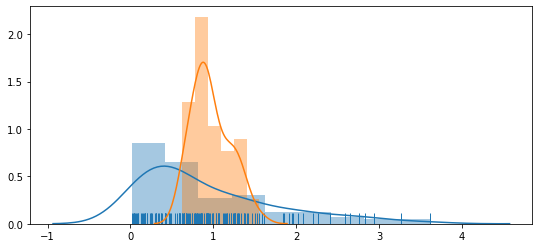

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
dist_rug(exp, ax)
dist_rug(means, ax)

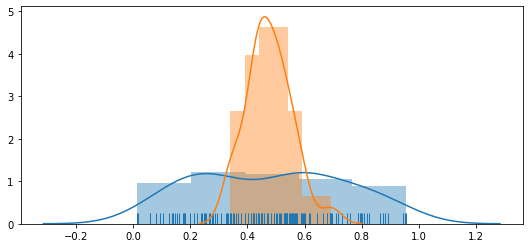

In [63]:
uni = np.random.uniform(size=100)
means = get_sample_means(uni, 30, 10)
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
dist_rug(uni, ax)
dist_rug(means, ax)

### the law of large numbers

As n increases the probability distribution of the sample converges to the probability distribution of the populaiton

In [ ]:
# flipping a coin
observed_vals = {}
n = 1000
for i in range(1, n):
    tosses = np.random.randint(0, 2, size=i)
    exp_val = np.mean(tosses)
    observed_vals[i] = exp_val

In [ ]:
observed_x, observed_y = dict2array(observed_vals.keys()), dict2array(observed_vals.values())
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(observed_x, observed_y)
ax.set(ylabel='avg value', xlabel='no. coin tosses', title='law of large numbers')
ax.axhline(0.5, ls='--', c='orange')
plt.plot()

### statistical tests

- chi squared
- logistic regression
- t-test
- ANOVA
- linear regression
- multivariate regression

#### chi square test

In [3]:
data = np.array([
    [8.9, 1.1],
    [5, 5],
])

In [46]:
def chi(data):
    x = (data[0] - data[1])**2
    return sum(x / data[1])

chi(data)

from scipy.stats import chisquare, chi2

o = np.array([30, 14, 34, 45, 57, 20])
e = np.array([20, 20, 30, 40, 60, 30])

critical = chi2.isf(q=0.05, df=5)
chi_val = chisquare(f_obs=o, f_exp=e)

print(f'critical: {critical},\n chi_val: {chi_val}')

### t test

In [ ]:
N = 500
a = np.random.randn(30)
b = np.random.randn(40) + 0.5

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3.5))
ax.hist(a, alpha=0.5)
ax.hist(b, alpha=0.5)
plt.plot()

In [ ]:
t, pv = stats.ttest_ind(a, b)
print(t, pv)

In [ ]:
# manual calc
a_mn, b_mn = np.mean(a), np.mean(b)
signal = a_mn - b_mn

a_var, b_var = a.var(ddof=1), b.var(ddof=1)
a_n, b_n = len(a), len(b)
noise = np.sqrt((a_var/a_n) + (b_var/b_n))

df = (a_n + b_n) - 2
t = signal / noise
p = stats.t.cdf(t, df=df) * 2

print(t, p)